In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil

In [2]:
# Loads csv files and appends pixels to X and labels to y
data = pd.read_csv('fer2013.csv')
labels = pd.read_csv('fer2013new.csv')

orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

n_samples = len(data)
w = 48
h = 48

y = np.array(labels[orig_class_names])
X = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
      X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))


In [3]:
 # Using mask to remove unknown or NF images
y_mask = y.argmax(axis=-1)
mask = y_mask < orig_class_names.index('unknown')
X = X[mask]
y = y[mask]
 # Convert to probabilities between 0 and 1
y = y[:, :-2] * 0.1

# Add contempt to neutral and remove it
y[:, 0] += y[:, 7]
y = y[:, :7]

# Normalize image vectors
X = X / 255.0


In [4]:
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)


In [5]:
shift = 0.1
datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
datagen.fit(x_train)

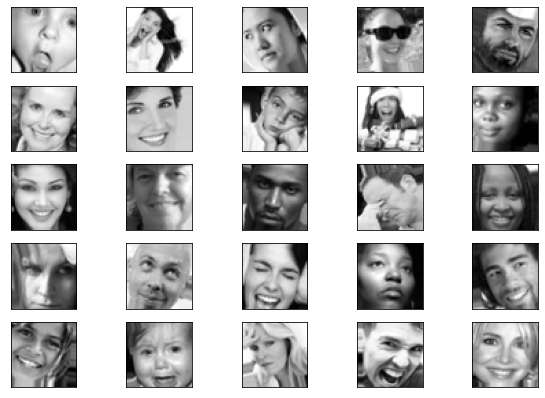

In [6]:
it = datagen.flow(x_train, y_train, batch_size=1)
plt.figure(figsize=(10, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(it.next()[0][0], cmap='gray')
    # plt.xlabel(class_names[y_train[i]])
plt.show()

In [7]:
input_shape=(48, 48, 1)
classes=7
num_features = 64
epochs = 15
batch_size = 64
fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

model = Sequential()
# 1st stage
model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.5))

 # 2nd stage
model.add(Conv2D(num_features, (3, 3), activation='relu'))
model.add(Conv2D(num_features, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd stage
model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

# 4th stage
model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 5th stage
model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(classes, activation='softmax'))


In [8]:
 # Training model from scratch

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 44, 44, 64)        0

In [9]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
 
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,steps_per_epoch=len(x_train) // batch_size,
                                 validation_data=(x_val, y_val), verbose=2)


Epoch 1/15
443/443 - 1518s - loss: 0.3419 - accuracy: 0.4101 - val_loss: 0.3779 - val_accuracy: 0.3781
Epoch 2/15
443/443 - 1424s - loss: 0.3104 - accuracy: 0.5272 - val_loss: 0.3467 - val_accuracy: 0.4863
Epoch 3/15
443/443 - 1728s - loss: 0.2892 - accuracy: 0.5822 - val_loss: 0.3314 - val_accuracy: 0.5621
Epoch 4/15
443/443 - 1448s - loss: 0.2713 - accuracy: 0.6230 - val_loss: 0.2602 - val_accuracy: 0.6264
Epoch 5/15
443/443 - 1412s - loss: 0.2606 - accuracy: 0.6462 - val_loss: 0.2511 - val_accuracy: 0.6779
Epoch 6/15
443/443 - 1415s - loss: 0.2517 - accuracy: 0.6690 - val_loss: 0.2396 - val_accuracy: 0.7053
Epoch 7/15
443/443 - 1411s - loss: 0.2452 - accuracy: 0.6854 - val_loss: 0.2354 - val_accuracy: 0.7067
Epoch 8/15
443/443 - 1415s - loss: 0.2401 - accuracy: 0.6967 - val_loss: 0.2264 - val_accuracy: 0.7382
Epoch 9/15
443/443 - 1405s - loss: 0.2345 - accuracy: 0.7107 - val_loss: 0.2239 - val_accuracy: 0.7377
Epoch 10/15
443/443 - 1410s - loss: 0.2303 - accuracy: 0.7194 - val_loss:

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

56/56 [==============================] - 29s 522ms/step - loss: 0.2073 - accuracy: 0.7771


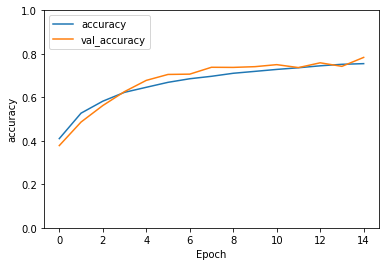

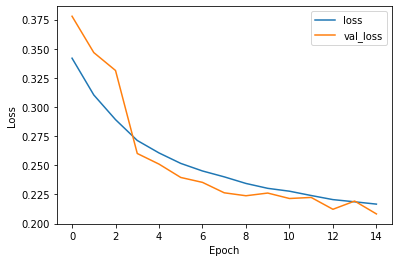

In [12]:
 # Plot accuracy graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1.0])
plt.legend(loc='upper left')
plt.show()

# Plot loss graph
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 3.5])
plt.legend(loc='upper right')
plt.show()


In [13]:
 # Serialize and save model to JSON
test_acc = int(test_acc * 10000)
model_json = model.to_json()
with open('model1' + str(test_acc) + '.json', 'w') as json_file:
    json_file.write(model_json)
# Serialize and save weights to JSON
model.save_weights('model1' + str(test_acc) + '.h5')
print('Model and weights are saved in separate files.')

Model and weights are saved in separate files.
